In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns



train_data = pd.read_csv('train.csv') 
test_data = pd.read_csv('test.csv')

train_data['Sex'] = train_data['Sex'].apply(lambda x : 1 if x=='male' else 0)
test_data['Sex'] = test_data['Sex'].apply(lambda x : 1 if x=='male' else 0)


# EDA

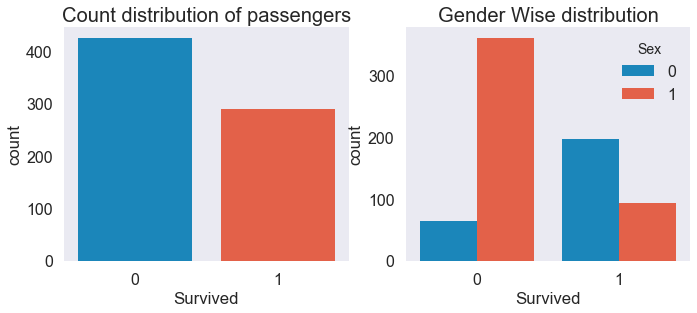

In [18]:
plt.style.use('seaborn-dark')

plt.figure(figsize=(10,4))
plt.subplot(121)
sns.countplot(train_data['Survived'])
plt.title('Count distribution of passengers')

plt.subplot(122)
sns.countplot(x='Survived',hue='Sex',data=train_data)
plt.title('Gender Wise distribution');


### Seeing null values distribution in the df

Text(0.5, 1.0, 'Test Data')

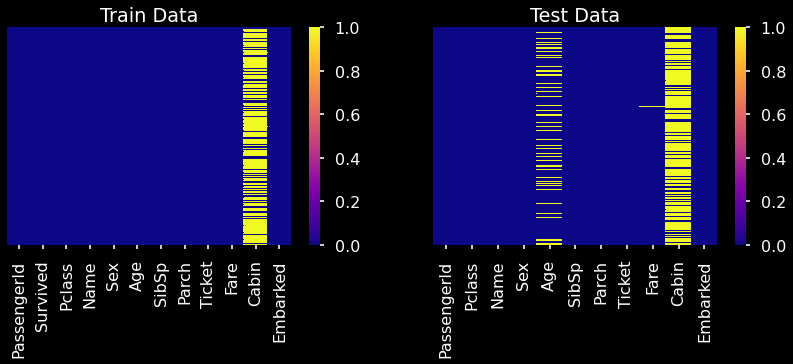

In [7]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.heatmap(train_data.isnull(),cmap = 'plasma',yticklabels=False)
plt.title('Train Data')

plt.subplot(122)
sns.heatmap(test_data.isnull(),cmap = 'plasma',yticklabels=False)
plt.title('Test Data')

# plt.xticks(rotation = '5')



## Distribution of survival rate with Pclass

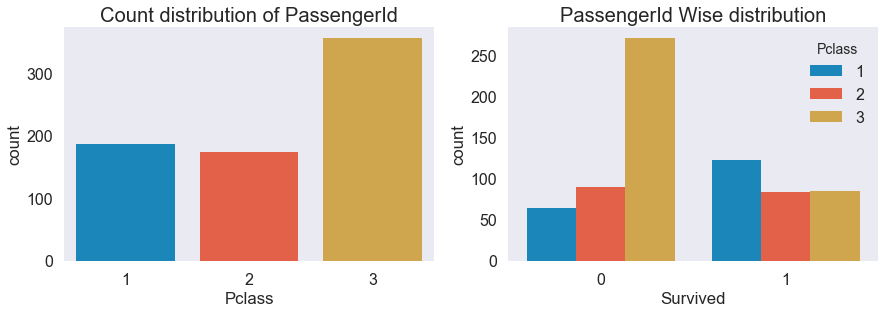

In [19]:
plt.style.use('seaborn-dark')

plt.figure(figsize=(13,4))
plt.subplot(121)
sns.countplot(train_data['Pclass'])
plt.title('Count distribution of PassengerId')

plt.subplot(122)
sns.countplot(x='Survived',hue='Pclass',data=train_data)
plt.title('PassengerId Wise distribution');


In [14]:
dx = train_data.groupby(['Pclass'])['Fare'].mean()

No handles with labels found to put in legend.


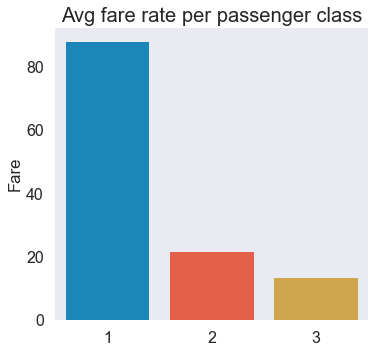

In [21]:
plt.figure(figsize=(5,5))
sns.barplot(x=[1,2,3],y=train_data.groupby(['Pclass'])['Fare'].mean())
plt.title('Avg fare rate per passenger class')


Looks like most of the passengers from class 3 (which has lowest fare) died . Coincidence or class disparity ?

# Correlation time

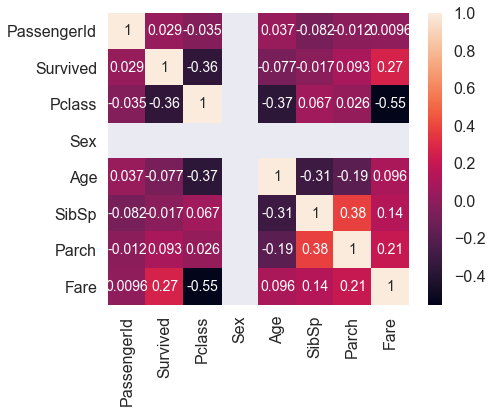

In [22]:

plt.figure(figsize=(6,5))
sns.heatmap(train_data.corr(),annot=True)

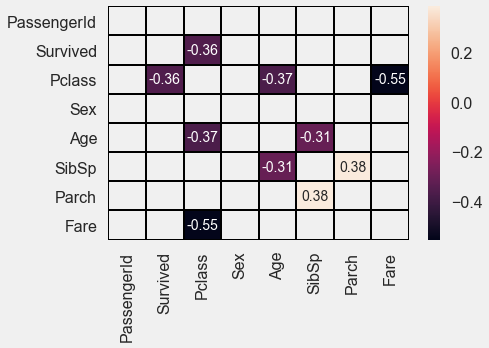

In [23]:
corr = train_data.corr()
corr = corr[((corr>=0.3) | (corr <= -0.3)) & (corr != 1)]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(6,4))
sns.heatmap(corr,annot=True,linewidths=1,linecolor='black',)

# Null handling

In [2]:
# train_data.groupby("Pclass").Age.transform('median').unique()

train_data.loc[train_data.Age.isnull(), 'Age'] = train_data.groupby("Pclass").Age.transform('median')
test_data.loc[test_data.Age.isnull(), 'Age'] = test_data.groupby("Pclass").Age.transform('median')

train_data['Embarked'] = train_data['Embarked'].fillna('S')

test_data.loc[test_data.Fare.isnull(),'Fare']  = test_data.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))



In [49]:
#lets fill na values with the highest occuring values
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

# Feature Engineering

In [3]:
# to doo : Convert embarked to numerical , drop cabin-names,
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


encoder = OneHotEncoder()

temp = pd.DataFrame((encoder.fit_transform(train_data[['Embarked']])).toarray(),columns=['S','C','Q'])
train_data_featured = train_data.copy()
train_data_featured = train_data_featured.join(temp)
train_data_featured.drop(columns='Embarked',inplace=True)

temp = pd.DataFrame(encoder.transform(test_data[['Embarked']]).toarray(), columns=['S', 'C', 'Q'])
test_data_featured = test_data.copy()
test_data_featured = test_data_featured.join(temp)
test_data_featured.drop(columns='Embarked', inplace=True)

train_data_featured.drop(columns=['Name','Cabin','Ticket'],axis=1,inplace=True)
test_data_featured.drop(columns=['Name','Cabin','Ticket'],axis=1,inplace=True)



In [18]:
def train_test_splits(df):
    
    from sklearn.model_selection import train_test_split
    
#     col_list = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Fare', 'S', 'C', 'Q']
    col_list = ['Pclass', 'Sex', 'Age', 'Family','Fare', 'S', 'C', 'Q']
    X = df[col_list]
    Y = df['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

    return  X_train, X_test, y_train, y_test

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC()
grid_values = {'C':[0.01, 0.1, 1, 10, 100],'gamma':[0.01, 0.1, 1, 10, 100]}

grid_model = GridSearchCV(clf,param_grid=grid_values,scoring='roc_auc')
grid_model.fit(X,Y)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,validation_curve,train_test_split

# clf = RandomForestClassifier(n_jobs=-1)
# grid_values = {'max_features':[2,3,4,3.17,5,6],'max_depth' : [3,5,8,10,12,15,20]}
# grid_model = GridSearchCV(clf,param_grid=grid_values,scoring='roc_auc')
# grid_model.fit(X,Y)
# print(grid_model.best_params_)
# print(grid_model.best_score_)   # best score of .87


X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
clf = RandomForestClassifier()  
clf.fit(X_train,y_train)
# pred = clf.predict(X_test)
clf.score(X_test,y_test)

#this gave a test accuracy of 0.76315 (an improovement)


0.820627802690583

## Linear SVC

In [17]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()
# grid_values = {'n_neighbors':[1,3,5,10,12,15,18,20,25,30,35,40]}
# grid_model = GridSearchCV(knn,param_grid=grid_values,scoring='roc_auc')
# grid_model.fit(X,Y)



0.7852030962147343

In [7]:
def op(clf):
    pred = clf.predict(test_data_featured[col_list])
    op = pd.DataFrame(data = (test_data['PassengerId'],pred),index=None)
    op = op.T
    op.columns = ['PassengerId','Survived']
    op.to_csv(r'Submission.csv')
    
    return True

# op(clf)

## Feature Engineering 2
I now want to see how surivor rate differs according to the different columns : Age, EMb,etc

In [4]:
# grid = sns.FacetGrid(train_data_featured,row = 'Pclass',col='Survived')
# grid.map(plt.hist,'Age')
train_data_featured2 = train_data_featured.copy()
train_data_featured2['Family'] = train_data_featured['SibSp']  + train_data_featured['Parch'] +1
train_data_featured2.drop(columns=['SibSp','Parch'],inplace=True)
train_data_featured2.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,S,C,Q,Family
0,1,0,3,1,22.0,7.2500,0.0,0.0,1.0,2
1,2,1,1,0,38.0,71.2833,1.0,0.0,0.0,2
2,3,1,3,0,26.0,7.9250,0.0,0.0,1.0,1
3,4,1,1,0,35.0,53.1000,0.0,0.0,1.0,2
4,5,0,3,1,35.0,8.0500,0.0,0.0,1.0,1


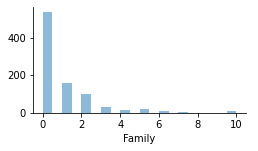

In [21]:
grid = sns.FacetGrid(train_data_featured2, size=2.2, aspect=1.6)
grid.map(plt.hist, 'Family', alpha=.5, bins=20)
grid.add_legend();

In [5]:
#thiis will help to see how survival rate is distributed across different age bands
train_data_featured2['AgeBand'] = pd.cut(train_data_featured2['Age'], 5)
train_data_featured2[['AgeBand','Survived']].groupby('AgeBand').mean()


#looking at the graph, it makes sense to categorize age groups into bands as different bands have differnt survival rates

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.336714
"(32.252, 48.168]",0.412844
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


In [6]:
train_data_featured2.loc[train_data_featured2.Age<16,'Age'] = 5
train_data_featured2.loc[(train_data_featured2.Age> 16) & (train_data_featured2.Age <= 32),'Age'] = 4
train_data_featured2.loc[(train_data_featured2.Age> 32) & (train_data_featured2.Age <= 48),'Age'] = 3
train_data_featured2.loc[(train_data_featured2.Age> 48) & (train_data_featured2.Age <= 64),'Age'] = 2
train_data_featured2.loc[(train_data_featured2.Age> 64),'Age'] = 1

test_data_featured2 = test_data_featured.copy()
test_data_featured2['AgeBand'] = pd.cut(test_data_featured2['Age'], 5)

test_data_featured2['Family'] = test_data_featured2['SibSp']  + test_data_featured2['Parch'] +1
test_data_featured2.loc[test_data_featured2.Age<16,'Age'] = 1
test_data_featured2.loc[(test_data_featured2.Age> 16) & (test_data_featured2.Age <= 32),'Age'] = 2
test_data_featured2.loc[(test_data_featured2.Age> 32) & (test_data_featured2.Age <= 48),'Age'] = 3
test_data_featured2.loc[(test_data_featured2.Age> 48) & (test_data_featured2.Age <= 64),'Age'] = 4
test_data_featured2.loc[(test_data_featured2.Age> 64),'Age'] = 5

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()  
clf.fit(X_train,y_train)
# pred = clf.predict(X_test)
clf.score(X_test,y_test)

#but this resulted in loow test accuracy 

0.8430493273542601

In [88]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 20, 30, 100]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_data_featured2[['Pclass','Sex','Age','Family','Fare','S','C','Q']],train_data_featured2['Survived'])



#no improovement in actual score here too :-( . So opted for the first model.

Fitting 3 folds for each of 792 candidates, totalling 2376 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 2268 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2369 out of 2376 | elapsed:  1.6min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 2376 out of 2376 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

# Part 3 : Exploring Voting from multiple classifiers

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

col_list = ['Pclass', 'Sex', 'Age', 'Family','Fare', 'S', 'C', 'Q']

X = train_data_featured2[col_list]
Y = train_data_featured2['Survived']
test_data_X = test_data_featured2[col_list]
kfold = StratifiedKFold(n_splits=10)

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier()

## Search grid for optimal parameters
clf1_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


model1 = GridSearchCV(clf1,param_grid = clf1_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

model1.fit(X,Y)

model1_bbest = model1.best_estimator_

# Best score
model1.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   56.4s finished


0.8339450686641697

In [12]:
from  sklearn.neighbors import KNeighborsClassifier
clf2 = KNeighborsClassifier()


## Search grid for optimal parameters
clf2_grid = {'n_neighbors':[3,4,5,6,7]}


model2 = GridSearchCV(clf2,param_grid = clf2_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

model2.fit(X,Y)

model2_bbest = model2.best_estimator_

# # Best score

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


0.8339450686641697

In [18]:
from sklearn.svm import SVC

clf3 = SVC(probability=True)
model3_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

model3 = GridSearchCV(clf3,param_grid = model3_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

model3.fit(X,Y)

# SVMC_best = gsSVMC.best_estimator_

# Best score
model3.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 272 tasks      | elapsed:   55.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:  1.1min finished


0.8125717852684146

In [25]:
from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[('rfc', model1.best_estimator_), ('knn', model2.best_estimator_),
('svc', model3.best_estimator_)], voting='soft', n_jobs=4)

votingC = votingC.fit(X, Y)


In [26]:
predict = votingC.predict(test_data_X)
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [30]:
op = pd.DataFrame(data = (test_data_featured2['PassengerId'],predict),index=None)
op = op.T
op.columns = ['PassengerId','Survived']
op.to_csv(r'Submission.csv')

In [31]:
np.bincount(predict)

array([304, 114])

In [32]:
## no improvement here too